In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [62]:
train = pd.read_csv("train.csv")
center = pd.read_csv("fulfilment_center_info.csv")
meal = pd.read_csv("meal_info.csv")
test = pd.read_csv("test_QoiMO9B.csv")

In [3]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [4]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [5]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [6]:
train.shape,center.shape,meal.shape,test.shape

((456548, 9), (77, 5), (51, 3), (32573, 8))

# 1. EDA

In [7]:
train.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

In [7]:
train.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [9]:
test.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

### No missing values, no imputations needed

In [8]:
len(train["center_id"].unique())

77

In [9]:
len(train["meal_id"].unique())

51

### Lets merge the 3 files

In [63]:
df = pd.merge(train,center,on="center_id")
data = pd.merge(df,meal,on = "meal_id")

In [64]:
data["source"] = "train"

In [65]:
df1 = pd.merge(test,center,on="center_id")
test = pd.merge(df1,meal,on = "meal_id")

In [66]:
test["source"] = "test"

In [67]:
data.shape,test.shape

((456548, 16), (32573, 15))

In [68]:
data = pd.concat([data,test],ignore_index=True)

In [69]:
data.shape

(489121, 16)

### Lets calculate the discount based on checkout price and base price

In [70]:
data["discount"] = data["base_price"] - data["checkout_price"]
data["discount_per"] = (data["discount"]/data["base_price"])*100

In [18]:
data.head(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,source,discount,discount_per
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai,train,15.46,10.151684
1,1018704,2,55,1885,135.83,152.29,0,0,323.0,647,56,TYPE_C,2.0,Beverages,Thai,train,16.46,10.808326


In [11]:
data.loc[data["discount"]<0].shape

(125038, 18)

Since there are some negative discounts also, that means there is increase in price of that meal

In [71]:
data["Price_increase"] = data["discount"].apply(lambda x: 1 if x <0 else 0)

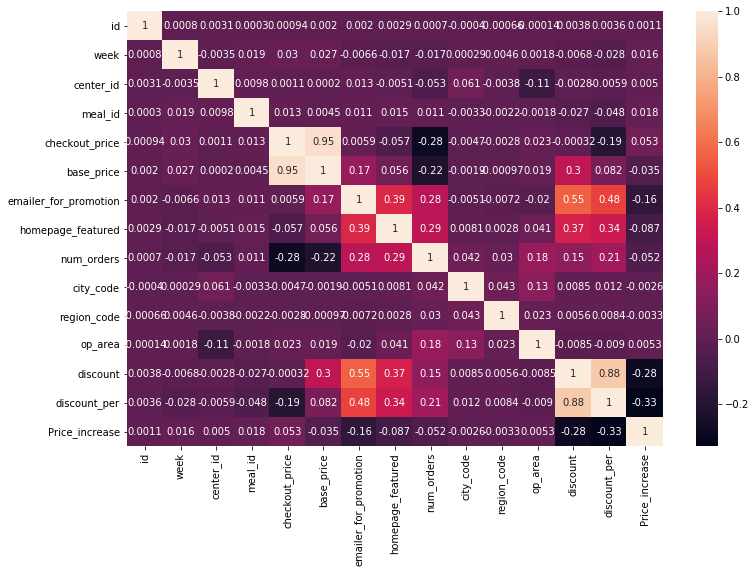

In [13]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(),annot = True)
plt.show()

## Observation
1. emailer promotion and homepage featured are highly positively correlated with num of orders.
2. checkout price, base price are highly negatively correlated with num of orders
3. number of orders is also positively correlated with operation area and the new column discount
4. checkout price and base price have perfectly positive correlation with each other
5. emailer promotion and homepage featured have positve correlationn with each other
6. discount has positive correlation with emailer promotion and homepage featured

# 2. Visualization
Based on above observation from heatmap lets visualize the data and their correlation

## 2.1 Univariate Analysis

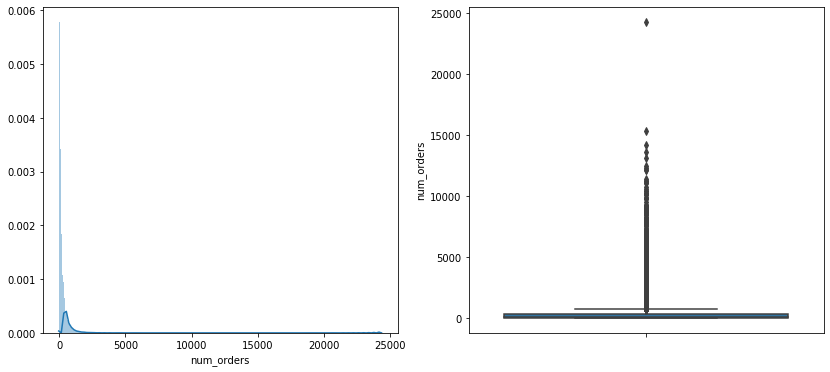

In [19]:
f, axes = plt.subplots(1,2, figsize=(14, 6),squeeze=False)
sns.distplot(data["num_orders"],bins = 500,ax = axes[0][0])
sns.boxplot(data["num_orders"],orient = "v",ax = axes[0][1])
plt.show()

### We can see the skewness, so we need to normalize the target variable

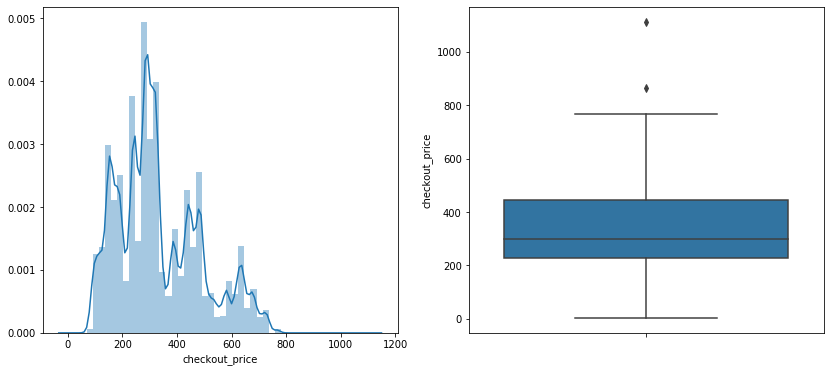

In [85]:
f, axes = plt.subplots(1,2, figsize=(14, 6),squeeze=False)
sns.distplot(data["checkout_price"],bins = 50,ax = axes[0][0])
sns.boxplot(data["checkout_price"],orient = "v",ax = axes[0][1])
plt.show()

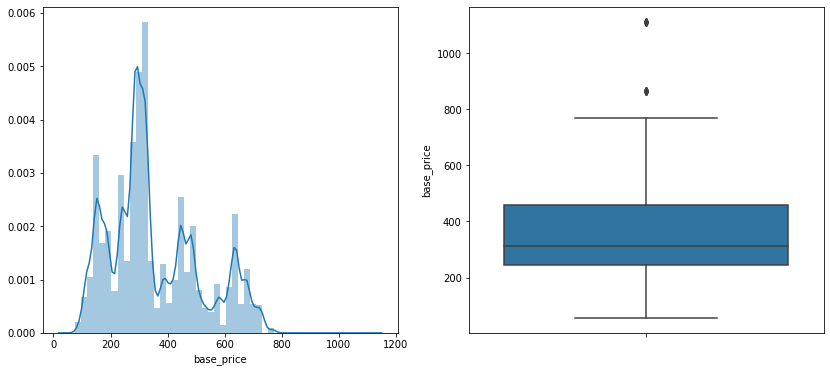

In [86]:
f, axes = plt.subplots(1,2, figsize=(14, 6),squeeze=False)
sns.distplot(data["base_price"],bins = 50,ax = axes[0][0])
sns.boxplot(data["base_price"],orient = "v",ax = axes[0][1])
plt.show()

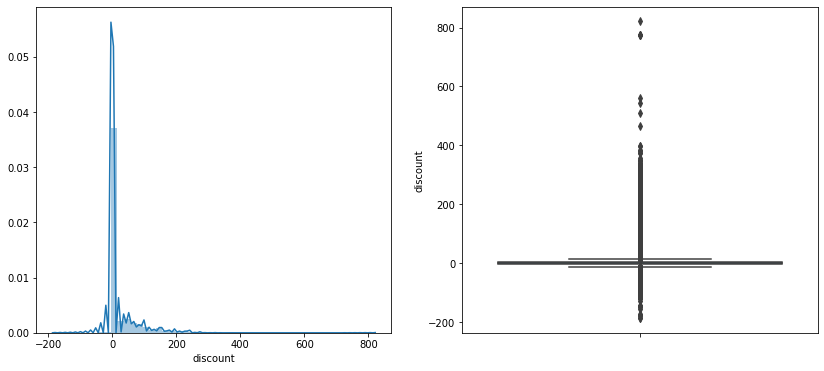

In [87]:
f, axes = plt.subplots(1,2, figsize=(14, 6),squeeze=False)
sns.distplot(data["discount"],bins = 50,ax = axes[0][0])
sns.boxplot(data["discount"],orient = "v",ax = axes[0][1])
plt.show()

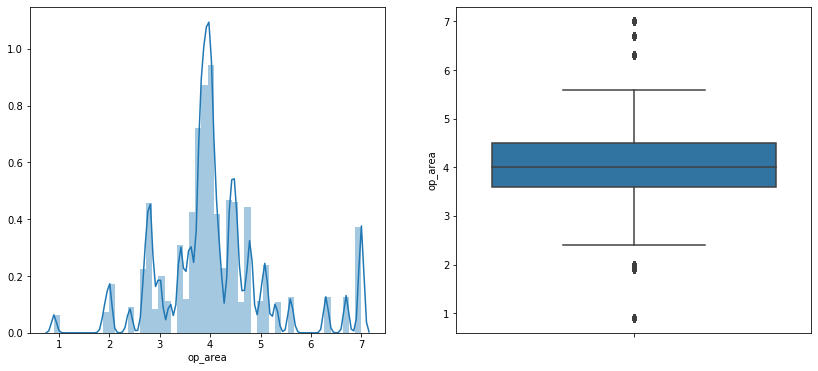

In [88]:
f, axes = plt.subplots(1,2, figsize=(14, 6),squeeze=False)
sns.distplot(data["op_area"],bins = 50,ax = axes[0][0])
sns.boxplot(data["op_area"],orient = "v",ax = axes[0][1])
plt.show()

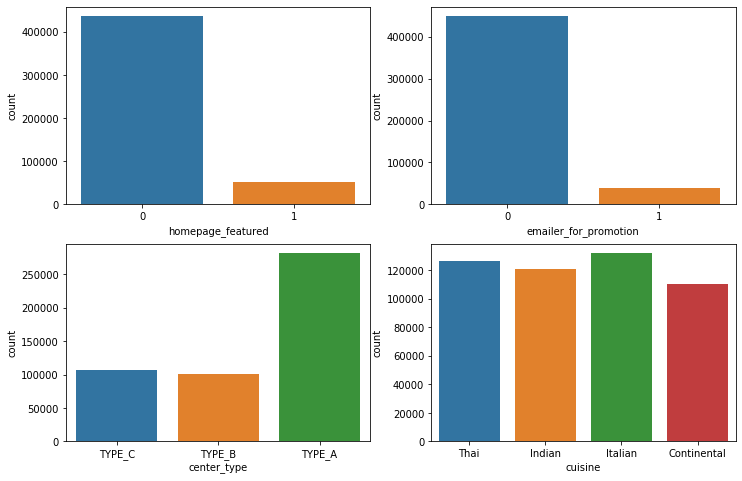

In [30]:
f,axes = plt.subplots(2,2,figsize = (12,8))
sns.countplot(x = data["homepage_featured"],data = data,ax = axes[0][0])
sns.countplot(x = data["emailer_for_promotion"],data = data,ax = axes[0][1])
sns.countplot(x = data["center_type"],data = data,ax = axes[1][0])
sns.countplot(x = data["cuisine"],data = data,ax = axes[1][1])
plt.show()

## 2.2 Multivariate Analysis

In [72]:
week = train.groupby(["week"])["num_orders"].sum().reset_index(name = "num_orders")
week = week.set_index("week")

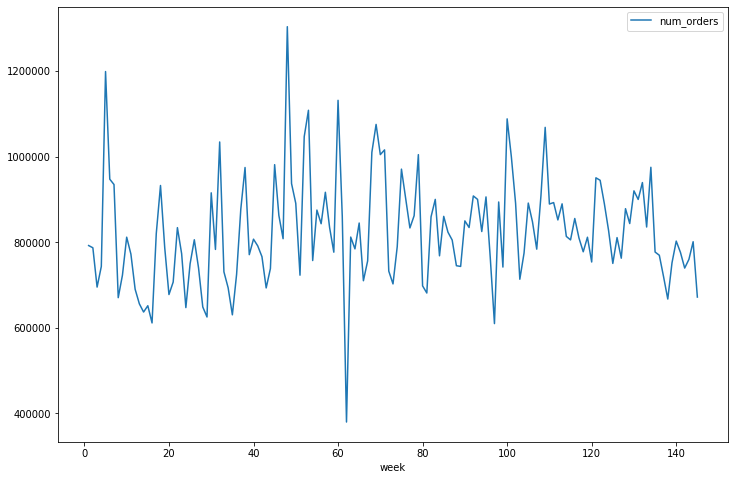

In [21]:
week.plot(figsize = (12,8))

### Observation
1. There might be an outlier.
2. There is no notable trend.
3. We can not see any seasonal pattern.

In [83]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


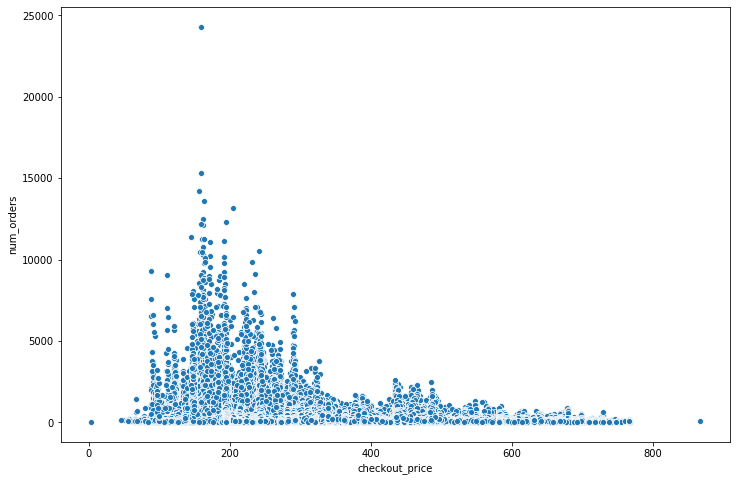

In [22]:
plt.figure(figsize = (12,8))
sns.scatterplot(x = data["checkout_price"],y=data["num_orders"],data = data)
plt.show()

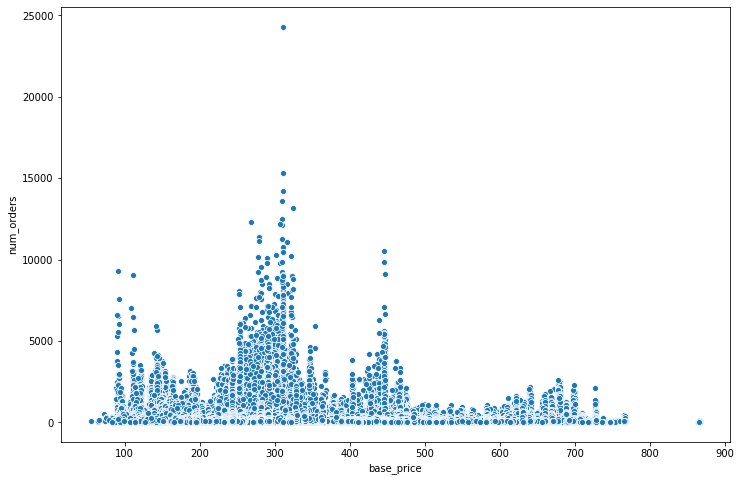

In [32]:
plt.figure(figsize = (12,8))
sns.scatterplot(x = data["base_price"],y=data["num_orders"],data = data)
plt.show()

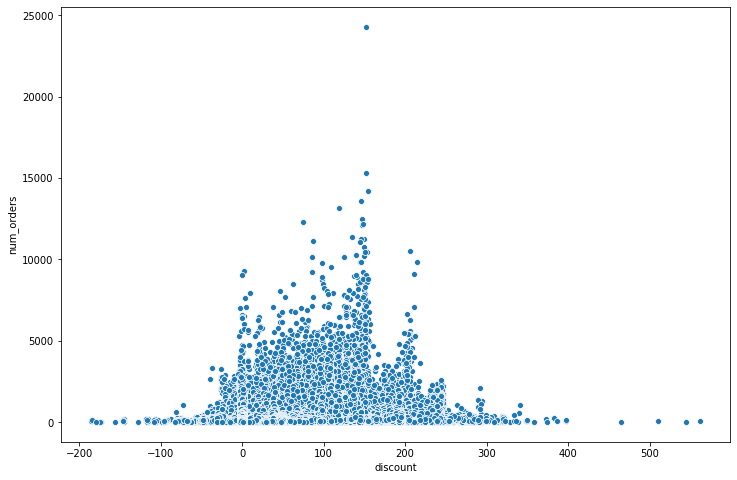

In [33]:
plt.figure(figsize = (12,8))
sns.scatterplot(x = data["discount"],y=data["num_orders"],data = data)
plt.show()

In [73]:
center_type = data.groupby("center_type")["num_orders"].sum().reset_index(name='num_orders')
homepage = data.groupby("homepage_featured")["num_orders"].sum().reset_index(name='num_orders')
email = data.groupby("emailer_for_promotion")["num_orders"].sum().reset_index(name='num_orders')
cuisine = data.groupby("cuisine")["num_orders"].sum().reset_index(name='num_orders')
area = data.groupby("op_area")["num_orders"].sum().reset_index(name='num_orders')
category = data.groupby("category")["num_orders"].sum().reset_index(name='num_orders')

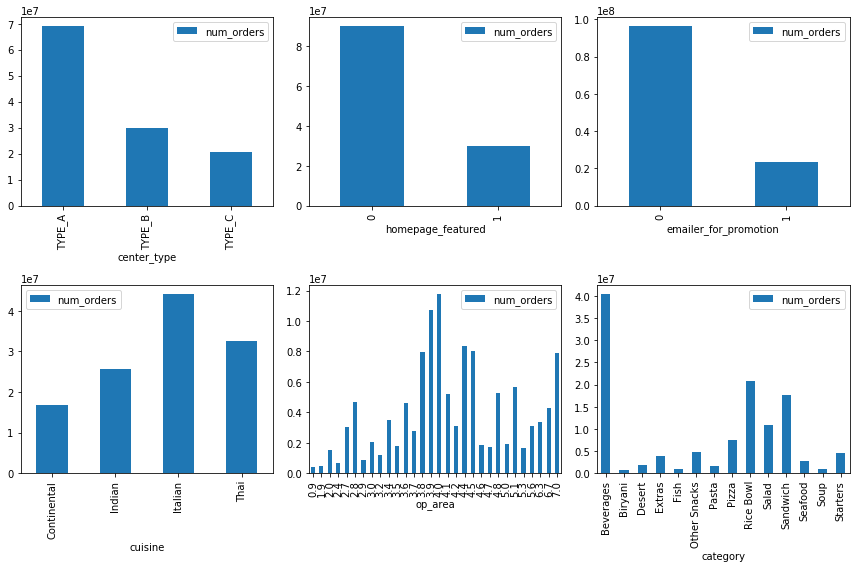

In [24]:
f, axes = plt.subplots(2,3,figsize = (12,8),tight_layout = True,)
center_type.plot.bar(x = "center_type",y = "num_orders",ax = axes[0][0])
homepage.plot.bar(x = "homepage_featured",y = "num_orders",ax = axes[0][1])
email.plot.bar(x = "emailer_for_promotion",y = "num_orders",ax = axes[0][2])
cuisine.plot.bar(x = "cuisine",y = "num_orders",ax = axes[1][0])
area.plot.bar(x = "op_area",y = "num_orders",ax = axes[1][1])
category.plot.bar(x = "category",y = "num_orders",ax = axes[1][2])
plt.show()

### Observation
1. number of orders decreases with increase in checkout price
2. Number of orders increases when there is a meal featured onn the homepage
3. Center Type A has the highest number of orders
4. Italian cuisine is in highest demand
5. Number of orders increases with increase in operating area
6. Beverages is in highest demand
7. There is not much difference between emai promotion and homepage featured so we can combine these two columns into  Campaign

In [74]:
data["campaign"] = data["emailer_for_promotion"] + data["homepage_featured"]

In [75]:
campaign = data.groupby("campaign")["num_orders"].sum().reset_index(name='num_orders')

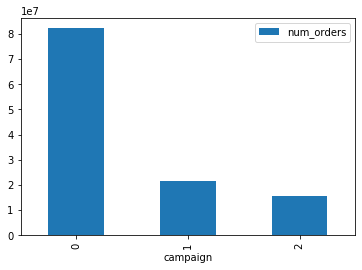

In [31]:
campaign.plot.bar(x = "campaign",y = "num_orders")

In [76]:
cuisine_cat = data.groupby(["cuisine","category"])["num_orders"].sum().reset_index(name='num_orders')

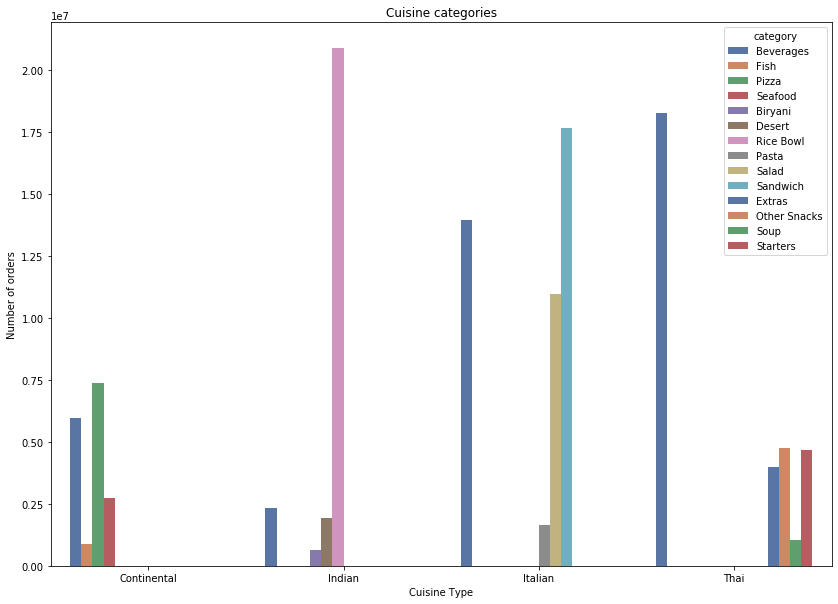

In [33]:
plt.figure(figsize = (14,10))
sns.barplot(x = "cuisine",y="num_orders",hue = "category",data = cuisine_cat,palette="deep")
plt.xlabel("Cuisine Type")
plt.ylabel("Number of orders")
plt.title("Cuisine categories")
plt.show()

1. We can see in Continental : Pizza is in more demand
2. Indian : Rice Bowl is in more demand
3. Italian : Beverages
4. Thai : Snacks

# 3. Prepare data for ML

### Outliers

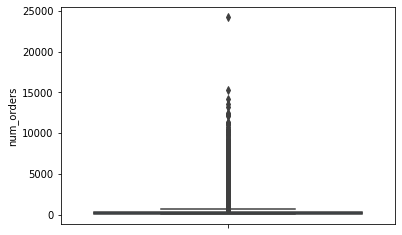

In [18]:
sns.boxplot(data["num_orders"],orient = "v")

In [77]:
data.loc[data["num_orders"] > 20000,"num_orders"] = 20000

### Removing irrelavant features

In [21]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,source,discount,discount_per,Price_increase,campaign
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai,train,15.46,10.151684,0,0
1,1018704,2,55,1885,135.83,152.29,0,0,323.0,647,56,TYPE_C,2.0,Beverages,Thai,train,16.46,10.808326,0,0
2,1196273,3,55,1885,132.92,133.92,0,0,96.0,647,56,TYPE_C,2.0,Beverages,Thai,train,1.00,0.746714,0,0
3,1116527,4,55,1885,135.86,134.86,0,0,163.0,647,56,TYPE_C,2.0,Beverages,Thai,train,-1.00,-0.741510,1,0
4,1343872,5,55,1885,146.50,147.50,0,0,215.0,647,56,TYPE_C,2.0,Beverages,Thai,train,1.00,0.677966,0,0


1. We need to remove emailer_for_promotion,homepage_featured

In [78]:
data.drop(["emailer_for_promotion","homepage_featured"],axis = 1,inplace = True)

### Hot coding

In [23]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,num_orders,city_code,region_code,center_type,op_area,category,cuisine,source,discount,discount_per,Price_increase,campaign
0,1379560,1,55,1885,136.83,152.29,177.0,647,56,TYPE_C,2.0,Beverages,Thai,train,15.46,10.151684,0,0
1,1018704,2,55,1885,135.83,152.29,323.0,647,56,TYPE_C,2.0,Beverages,Thai,train,16.46,10.808326,0,0
2,1196273,3,55,1885,132.92,133.92,96.0,647,56,TYPE_C,2.0,Beverages,Thai,train,1.00,0.746714,0,0
3,1116527,4,55,1885,135.86,134.86,163.0,647,56,TYPE_C,2.0,Beverages,Thai,train,-1.00,-0.741510,1,0
4,1343872,5,55,1885,146.50,147.50,215.0,647,56,TYPE_C,2.0,Beverages,Thai,train,1.00,0.677966,0,0


In [79]:
cat_features = ["center_type","category","cuisine"]

In [80]:
data = pd.get_dummies(data,columns=cat_features,drop_first=True)

In [28]:
data.shape

(489121, 33)

In [81]:
train = data.loc[data["source"] == "train"]
test = data.loc[data["source"] == "test"]

In [82]:
test.drop(["num_orders","source"],axis = 1, inplace = True)
train.drop(["source","id"],axis = 1,inplace = True)

In [25]:
train.shape,test.shape

((456548, 31), (32573, 30))

In [26]:
train.head()

,week,center_id,meal_id,checkout_price,base_price,num_orders,city_code,region_code,op_area,discount,...,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1,55,1885,136.83,152.29,177.0,647,56,2.0,15.46,...,0,0,0,0,0,0,0,0,0,1
1,2,55,1885,135.83,152.29,323.0,647,56,2.0,16.46,...,0,0,0,0,0,0,0,0,0,1
2,3,55,1885,132.92,133.92,96.0,647,56,2.0,1.00,...,0,0,0,0,0,0,0,0,0,1
3,4,55,1885,135.86,134.86,163.0,647,56,2.0,-1.00,...,0,0,0,0,0,0,0,0,0,1
4,5,55,1885,146.50,147.50,215.0,647,56,2.0,1.00,...,0,0,0,0,0,0,0,0,0,1


### Train Test split

In [27]:
target = "num_orders"
IDcol = ["id"]

In [28]:
features = [x for x in train.columns if x not in [target]+IDcol]

In [83]:
train_split = train[train["week"]<=101]

In [84]:
test_split = train[train["week"]>101]

In [85]:
X_train = train_split[features].values
y_train = train_split[target]

In [86]:
X_test = test_split[features].values
y_test = test_split[target]

In [33]:
X_train.shape,y_train.shape

((312585, 30), (312585,))

# 4. Train the model

In [34]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import math

## GridSearchCV - Hypermeter tuning

### LGBM Regressor

In [35]:
from sklearn.model_selection import TimeSeriesSplit

In [36]:
tscv = TimeSeriesSplit() 

In [37]:
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [43]:
def model_score(name,est,param,X_train,y_train,X_test,y_test,tscv):
    grid = GridSearchCV(estimator= est,param_grid = param,cv = tscv,verbose = 5,n_jobs = 3)
    results = grid.fit(X_train,y_train)
    print("Model Name ",name,"\n")
    print("Best Score of ",results.best_score_,"for Best parameters are \n",results.best_params_, )
    
    model = results.best_estimator_
    fit = model.fit(X_train,y_train)
    pred = fit.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test,pred))
    print("\n RMSE for ",name," : ",rmse)
    
    return(model)

In [91]:
lgm_param = {'num_leaves' :[30,100,125],
             'max_depth':[5,10],
             'learning_rate' : [0.1,0.5,1],
                'n_estimators':[50,100]}

In [40]:
lgbm =  LGBMRegressor(random_state=1234)

In [44]:
model_lgbm = model_score("LGBM",lgbm,lgm_param,X_train,y_train,X_test,y_test,tscv)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   18.6s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:  4.2min finished


Model Name  LGBM 

Best Score of  -0.07772220066601496 for Best parameters are 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves=125': 30}

 RMSE for  LGBM  :  210.88700065420522


In [47]:
#from catboost import CatBoostRegressor

In [48]:
#model = CatBoostRegressor(iterations=2,learning_rate=1,depth=2)
# Fit model
#model.fit(train_data, train_labels)
# Get predictions
#preds = model.predict(eval_data)

In [50]:
lgbm =  LGBMRegressor(num_leaves =30,max_depth=5,learning_rate=0.1,n_estimators=50,random_state=1234)


In [51]:
lgbm.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=30, objective=None,
              random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
pred = lgbm.predict(X_test)

In [53]:
rmse = math.sqrt(mean_squared_error(y_test,pred))

In [54]:
rmse

211.6340198561085

## Fit model on whole data

In [57]:
X = train.drop(["num_orders"],axis = 1)
Y = train["num_orders"]

In [58]:
lgbm.fit(X,Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=30, objective=None,
              random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [87]:
test[target] = lgbm.predict(test[features])

In [88]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,city_code,region_code,op_area,discount,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai,num_orders
456548,1028232,146,55,1885,158.11,159.11,647,56,2.0,1.0,...,0,0,0,0,0,0,0,0,1,260.124468
456549,1262649,147,55,1885,159.11,159.11,647,56,2.0,0.0,...,0,0,0,0,0,0,0,0,1,260.124468
456550,1453211,149,55,1885,157.14,158.14,647,56,2.0,1.0,...,0,0,0,0,0,0,0,0,1,260.124468
456551,1262599,150,55,1885,159.14,157.14,647,56,2.0,-2.0,...,0,0,0,0,0,0,0,0,1,260.124468
456552,1495848,151,55,1885,160.11,159.11,647,56,2.0,-1.0,...,0,0,0,0,0,0,0,0,1,260.124468


In [89]:
submission = test[["id","num_orders"]]

In [96]:
submission.to_csv("submission.csv",index=False)